# 2D DPP conforming Galerkin FEM

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd


from perphil.forms.spaces import create_function_spaces
from perphil.forms.dpp import dpp_form
from perphil.mesh.builtin import create_mesh
from perphil.models.dpp.parameters import DPPParameters
from perphil.solvers.conditioning import (
    get_matrix_data_from_form,
    calculate_condition_number,
)
from perphil.solvers.solver import (
    solve_dpp,
    solve_dpp_nonlinear,
)
from perphil.solvers.parameters import (
    LINEAR_SOLVER_PARAMS,
    GMRES_PARAMS,
    FIELDSPLIT_LU_PARAMS,
    GMRES_JACOBI_PARAMS,
    GMRES_ILU_PARAMS,
    NGS_SOLVER_PARAMS,
)
from perphil.utils.plotting import plot_2d_mesh, plot_scalar_field, plot_vector_field
from perphil.utils.manufactured_solutions import interpolate_exact
from perphil.utils.postprocessing import (
    split_dpp_solution,
    calculate_darcy_velocity_from_pressure,
    slice_along_x,
)

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Mesh

In [3]:
mesh = create_mesh(10, 10, quadrilateral=True)

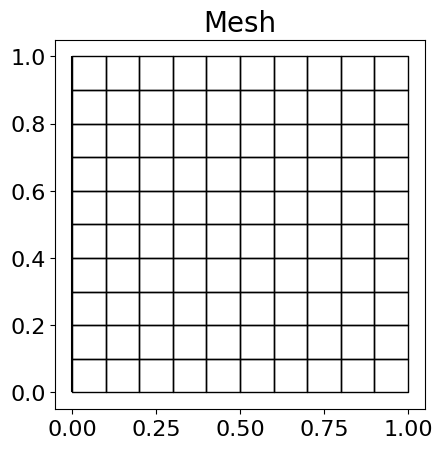

In [4]:
plot_2d_mesh(mesh)

### Exact solutions

In [5]:
U, V = create_function_spaces(
    mesh,
    velocity_deg=1,
    pressure_deg=1,
    velocity_family="CG",
    pressure_family="CG",
)

dpp_params = DPPParameters(k1=1.0, k2=1 / 1e2, beta=1.0, mu=1)
u1_exact, p1_exact, u2_exact, p2_exact = interpolate_exact(mesh, U, V, dpp_params)

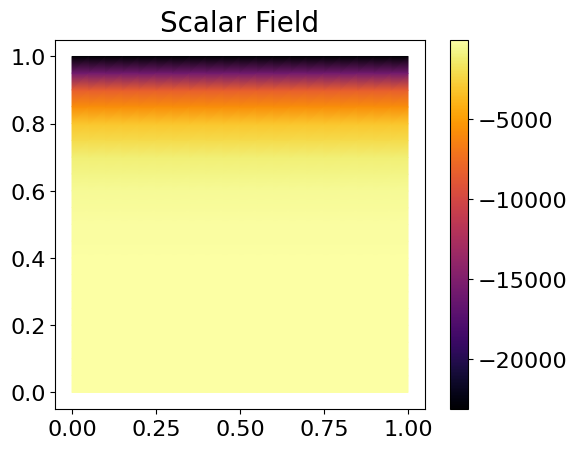

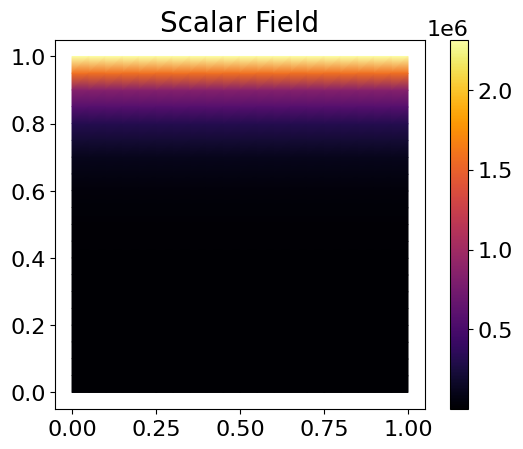

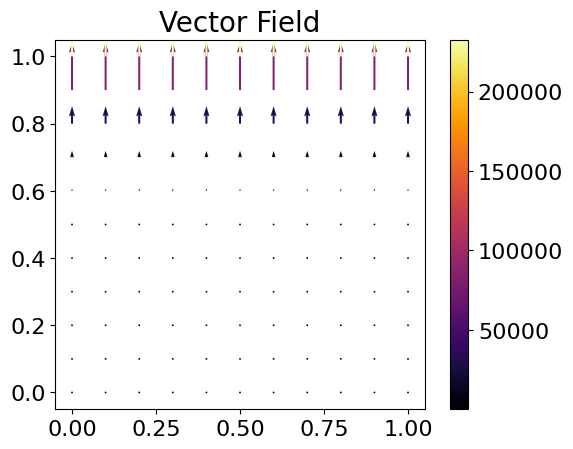

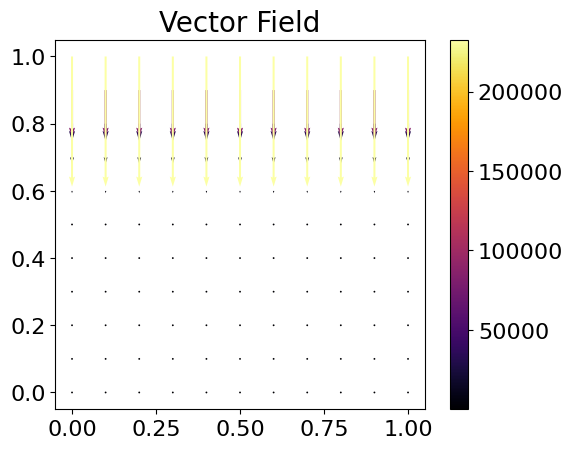

In [6]:
plot_scalar_field(p1_exact)
plot_scalar_field(p2_exact)
plot_vector_field(u1_exact)
plot_vector_field(u2_exact)

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [7]:
W = V * V  # Mixed function space with both scales

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

solver_parameters = LINEAR_SOLVER_PARAMS
solution_data_monolithic = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_monolithic = solution_data_monolithic.solution
p1_monolithic, p2_monolithic = split_dpp_solution(solution_monolithic)

u1_monolithic = calculate_darcy_velocity_from_pressure(p1_monolithic, dpp_params.k1)

u2_monolithic = calculate_darcy_velocity_from_pressure(p2_monolithic, dpp_params.k2)

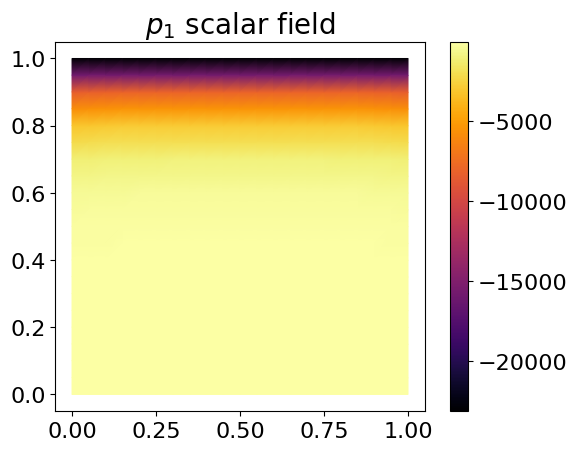

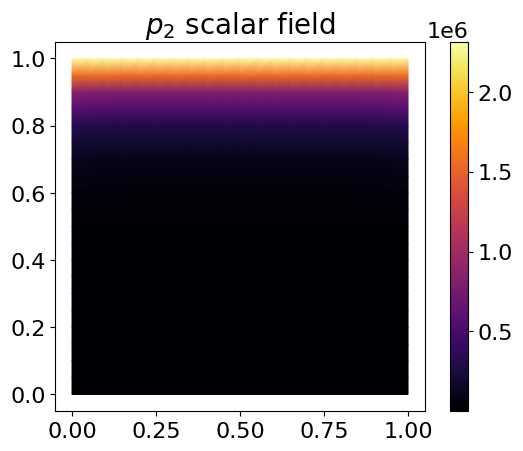

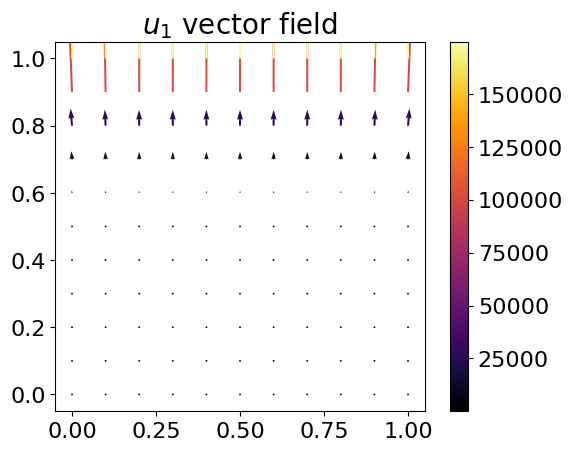

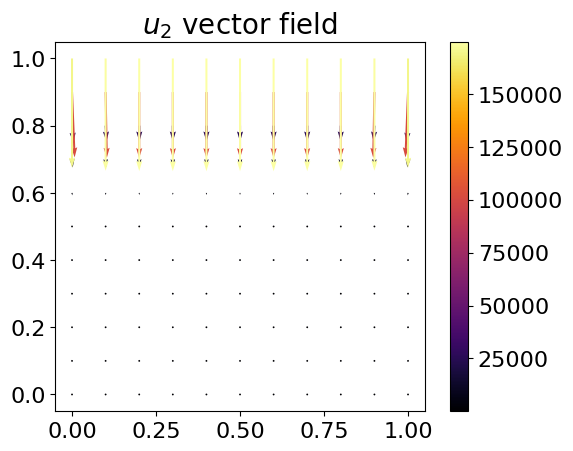

In [8]:
plot_scalar_field(p1_monolithic, title=r"$p_1$ scalar field")
plot_scalar_field(p2_monolithic, title=r"$p_2$ scalar field")
plot_vector_field(u1_monolithic, title=r"$u_1$ vector field")
plot_vector_field(u2_monolithic, title=r"$u_2$ vector field")

In [9]:
x_mid_point = 0.5
y_points, p1_mono_at_x_mid_point = slice_along_x(p1_monolithic, x_value=x_mid_point)
_, p1_exact_at_x_mid_point = slice_along_x(p1_exact, x_value=x_mid_point)
_, p2_mono_at_x_mid_point = slice_along_x(p2_monolithic, x_value=x_mid_point)
_, p2_exact_at_x_mid_point = slice_along_x(p2_exact, x_value=x_mid_point)

y_points, p1_mono_at_x_mid_point, p2_mono_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946480e+00, -4.38933558e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

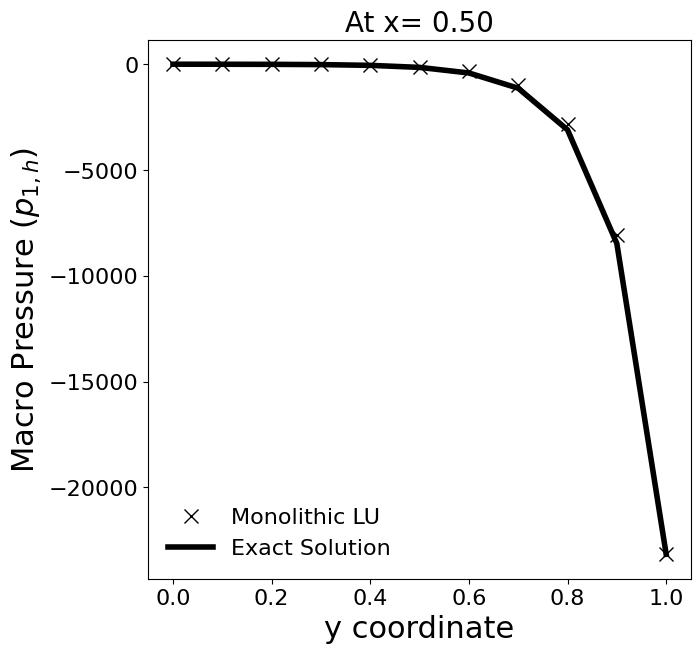

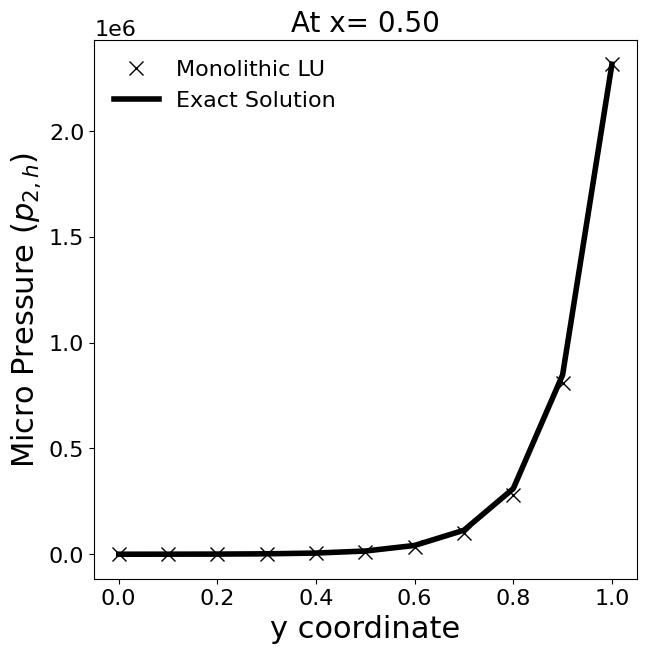

In [10]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [11]:
solver_additional_param = {
    "ksp_monitor": None,
    "snes_monitor": None,
    "snes_rtol": 1e-8,
    "snes_atol": 1e-12,
}
solver_parameters = {**GMRES_PARAMS, **FIELDSPLIT_LU_PARAMS, **solver_additional_param}
solution_data_preconditioned = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_preconditioned = solution_data_preconditioned.solution
p1_preconditioned, p2_preconditioned = split_dpp_solution(solution_preconditioned)

u1_preconditioned = calculate_darcy_velocity_from_pressure(
    p1_preconditioned, dpp_params.k1
)

u2_preconditioned = calculate_darcy_velocity_from_pressure(
    p2_preconditioned, dpp_params.k2
)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.579294048667e+06
    1 KSP Residual norm 4.826558204558e+04
    2 KSP Residual norm 7.122478054650e+02
    3 KSP Residual norm 4.055258380528e+00
    4 KSP Residual norm 8.155414748172e-03
    5 KSP Residual norm 7.145565823259e-06
    6 KSP Residual norm 5.245017940560e-09
  1 SNES Function norm 9.135368710683e-09


In [12]:
solver_parameters = {**GMRES_JACOBI_PARAMS, **solver_additional_param}
solution_data_gmres_jacobi = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_gmres_jacobi = solution_data_gmres_jacobi.solution
p1_gmres_jacobi, p2_gmres_jacobi = split_dpp_solution(solution_gmres_jacobi)

u1_gmres_jacobi = calculate_darcy_velocity_from_pressure(p1_gmres_jacobi, dpp_params.k1)

u2_gmres_jacobi = calculate_darcy_velocity_from_pressure(p2_gmres_jacobi, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 1.928816876943e+06
    1 KSP Residual norm 5.338040265445e+05
    2 KSP Residual norm 1.720021586590e+05
    3 KSP Residual norm 5.679123808532e+04
    4 KSP Residual norm 1.877121187171e+04
    5 KSP Residual norm 6.100994208874e+03
    6 KSP Residual norm 2.014884089703e+03
    7 KSP Residual norm 6.624058878822e+02
    8 KSP Residual norm 2.238209610088e+02
    9 KSP Residual norm 6.461370402885e+01
   10 KSP Residual norm 4.890017856838e+01
   11 KSP Residual norm 3.293092016419e+01
   12 KSP Residual norm 1.932543678678e+01
   13 KSP Residual norm 1.552282667896e+01
   14 KSP Residual norm 9.604268477585e+00
   15 KSP Residual norm 2.781934118569e+00
   16 KSP Residual norm 7.852621188043e-01
   17 KSP Residual norm 3.696598362630e-01
   18 KSP Residual norm 1.641574167698e-01
   19 KSP Residual norm 2.797739250967e-02
   20 KSP Residual norm 4.905458961745e-03
   21 KSP Residual n

In [13]:
solver_parameters = {**GMRES_ILU_PARAMS, **solver_additional_param}
solution_data_gmres_ilu = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_gmres_ilu = solution_data_gmres_ilu.solution
p1_gmres_ilu, p2_gmres_ilu = split_dpp_solution(solution_gmres_ilu)

u1_gmres_ilu = calculate_darcy_velocity_from_pressure(p1_gmres_ilu, dpp_params.k1)

u2_gmres_ilu = calculate_darcy_velocity_from_pressure(p2_gmres_ilu, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.500673542910e+06
    1 KSP Residual norm 6.249746549991e+04
    2 KSP Residual norm 1.722924063135e+03
    3 KSP Residual norm 6.378077431109e+01
    4 KSP Residual norm 7.304251543972e+00
    5 KSP Residual norm 1.734893708425e+00
    6 KSP Residual norm 6.838604376744e-01
    7 KSP Residual norm 6.694765249472e-02
    8 KSP Residual norm 8.084456241843e-03
    9 KSP Residual norm 4.974535608622e-04
   10 KSP Residual norm 3.514280331679e-05
   11 KSP Residual norm 3.688641416004e-06
   12 KSP Residual norm 2.959510005609e-07
  1 SNES Function norm 2.197581166591e-07


In [ ]:
y_points, p1_pc_at_x_mid_point = slice_along_x(p1_preconditioned, x_value=x_mid_point)
_, p2_pc_at_x_mid_point = slice_along_x(p2_preconditioned, x_value=x_mid_point)

y_points, p1_pc_at_x_mid_point, p2_pc_at_x_mid_point

In [ ]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations:

In [ ]:
solver_parameters = {**NGS_SOLVER_PARAMS, **solver_additional_param}
solution_data_ngs = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_ngs = solution_data_ngs.solution
p1_picard, p2_picard = split_dpp_solution(solution_ngs)

u1_picard = calculate_darcy_velocity_from_pressure(p1_picard, dpp_params.k1)

u2_picard = calculate_darcy_velocity_from_pressure(p2_picard, dpp_params.k2)

In [ ]:
y_points, p1_picard_at_x_mid_point = slice_along_x(p1_picard, x_value=x_mid_point)
_, p2_picard_at_x_mid_point = slice_along_x(p2_picard, x_value=x_mid_point)

y_points, p1_picard_at_x_mid_point, p2_picard_at_x_mid_point

In [ ]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p1_picard_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard",
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Loop-based Picard"
)
plt.plot(y_points, p2_picard_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Conditioning Analysis

##### Monolithic system

In [ ]:
monolithic_lhs_form, _ = dpp_form(W=W, model_params=dpp_params)
matrix_data = get_matrix_data_from_form(monolithic_lhs_form, boundary_conditions=bcs)
monolithic_system_condition_number = calculate_condition_number(
    matrix_data.sparse_csr_data,
    num_of_factors=matrix_data.number_of_dofs - 1,
)
print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

##### Scale-splitting

In [ ]:
# # Macro
# A_macro = fd.assemble(a_macro, bcs=bc_macro, mat_type="aij")
# petsc_mat_macro = A_macro.M.handle
# is_symmetric_macro = petsc_mat_macro.isSymmetric(tol=1e-8)
# size_macro = petsc_mat_macro.getSize()
# Mnp_macro = csr_matrix(petsc_mat_macro.getValuesCSR()[::-1], shape=size_macro)

# # Micro
# A_micro = fd.assemble(a_micro, bcs=bc_micro, mat_type="aij")
# petsc_mat_micro = A_micro.M.handle
# is_symmetric_micro = petsc_mat_micro.isSymmetric(tol=1e-8)
# size_micro = petsc_mat_micro.getSize()
# Mnp_micro = csr_matrix(petsc_mat_micro.getValuesCSR()[::-1], shape=size_micro)

In [ ]:
# Mnp_macro.eliminate_zeros()
# nnz = Mnp_macro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Macro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [ ]:
# Mnp_micro.eliminate_zeros()
# nnz = Mnp_micro.nnz
# number_of_dofs = V.dim()
# num_of_factors = int(number_of_dofs) - 1

# print(f"Number of Degrees of Freedom (Micro): {number_of_dofs}")
# print(f"Number of non-zero entries: {nnz}")
# print(f"Is operator symmetric? {is_symmetric}")
# print(f"Number of factors to compute in SVD: {num_of_factors}")

In [ ]:
# macro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_macro, num_of_factors=num_of_factors
# )
# micro_system_condition_number = calculate_condition_number(
#     A=petsc_mat_micro, num_of_factors=num_of_factors
# )

# print(f"Macro system Condition Number: {macro_system_condition_number}")
# print(f"Micro system Condition Number: {micro_system_condition_number}")